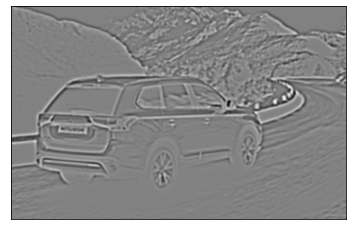

In [79]:
import math
import scipy as sp
import numpy as np
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import cv2

img = cv2.imread('Car On Mountain Road (1).tif', 0).astype(np.float32)/255.
LoG = nd.gaussian_laplace(img, 4)

plt.imshow(LoG, cmap="gray")
plt.xticks([])
plt.yticks([])
plt.show()

In [80]:
def show_image(image):
    plt.imshow(image, cmap="gray")
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [81]:
def zero_crossing(LoG, thres):
    output = np.zeros(LoG.shape)
    w = output.shape[1]
    h = output.shape[0]

    for y in range(1, h - 1):
        for x in range(1, w - 1):
            patch = LoG[y-1:y+2, x-1:x+2]
            p = LoG[y, x]
            maxP = patch.max()
            minP = patch.min()

            if (p > 0):
                zeroCross = True if minP < 0 else False
            else:
                zeroCross = True if maxP > 0 else False
            if ((maxP - minP) > thres) and zeroCross:
                output[y, x] = 1

    show_image(output)
    
    return output

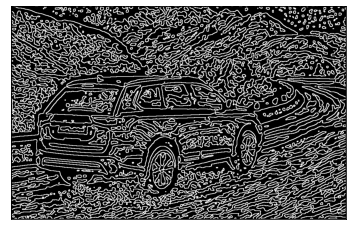

In [82]:
zc_log = zero_crossing(LoG, thres=0)

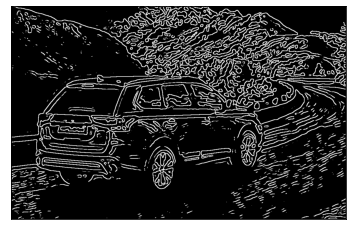

In [83]:
zc_log = zero_crossing(LoG, thres=LoG.max()*0.04)

In [84]:
zc_log = np.copy(zc_log)

In [85]:
zc_log = ((zc_log - zc_log.min())/(zc_log.max() - zc_log.min()) * 255).astype(np.uint8)
zc_log = np.expand_dims(zc_log, -1)

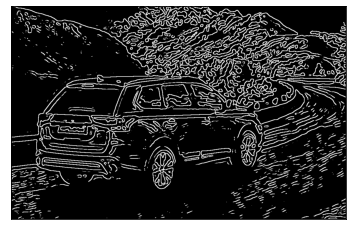

In [86]:
show_image(zc_log)

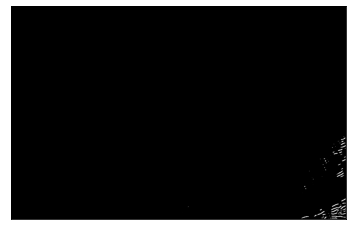

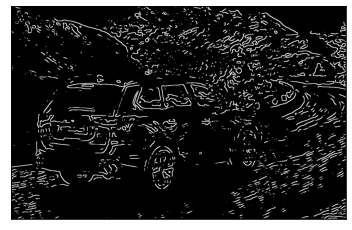

In [87]:
# https://docs.opencv.org/3.4/d9/db0/tutorial_hough_lines.html
# Copy edges to the images that will display the results in BGR
cdst = np.copy(zc_log)
cdstP = np.copy(cdst)

lines = cv2.HoughLines(zc_log, 1, np.pi / 180, 150, None, 0, 0)

if lines is not None:
    for i in range(0, len(lines)):
        rho = lines[i][0][0]
        theta = lines[i][0][1]
        a = math.cos(theta)
        b = math.sin(theta)
        x0 = a * rho
        y0 = b * rho
        pt1 = (int(x0 + 1000*(-b)), int(y0 + 1000*(a)))
        pt2 = (int(x0 - 1000*(-b)), int(y0 - 1000*(a)))
        cv2.line(cdst, pt1, pt2, (0,0,255), 3, cv2.LINE_AA)


linesP = cv2.HoughLinesP(zc_log, 1, np.pi / 180, 50, None, 50, 10)

if linesP is not None:
    for i in range(0, len(linesP)):
        l = linesP[i][0]
        cv2.line(cdstP, (l[0], l[1]), (l[2], l[3]), (0,0,255), 3, cv2.LINE_AA)

show_image(cdstP) # "Detected Lines (in red) - Probabilistic Line Transform"

In [ ]:
import cv2
import numpy as np


# originalImage = cv2.imread('Input.jpg',1)
originalImage = cv2.imread('Car On Mountain Road (1).tif', 0)
#originalImage = cv2.imread('/Users/mitalibhiwande/Downloads/coins1.jpg',0)
#originalImage = cv2.imread('/Users/mitalibhiwande/Downloads/HoughCircles.jpg',1)
cv2.imshow('Original Image',originalImage)

output = originalImage.copy()

#Applying Gausssian Blur on input image
blurredImage = cv2.GaussianBlur(originalImage,(3,3),0)
cv2.imshow('Gaussian Blurred Image',blurredImage)

#Detecting edges in Image using Canny edge Detector
edgeDetectedImage = cv2.Canny(blurredImage,60,100)
cv2.imshow('Edge Detected Image', edgeDetectedImage)

#im = cv2.imread("/Users/mitalibhiwande/Downloads/HoughCircles.jpg",cv2.IMREAD_GRAYSCALE)
im = cv2.imread("Input.jpg",cv2.IMREAD_GRAYSCALE)
params = cv2.SimpleBlobDetector_Params()

# Change thresholds
params.minThreshold = 50
params.maxThreshold = 200


# Filter by Area.
#params.filterByArea = True
#params.minArea = 1500

## Filter by Circularity
#params.filterByCircularity = True
#params.minCircularity = 0.8
#
## Filter by Convexity
#params.filterByConvexity = True
#params.minConvexity = 0.87
#    
## Filter by Inertia
#params.filterByInertia = True
#params.minInertiaRatio = 0.01

detector = cv2.SimpleBlobDetector()

keypoints=detector.detect(im)
#print keypoints.
keys=cv2.drawKeypoints(edgeDetectedImage,keypoints,np.array([]), (0,0,255), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

sizes=[]
for keyPoint in keypoints:
    
    x = keyPoint.pt[0]
    y = keyPoint.pt[1]
    s = keyPoint.size
    sizes.append(s)
    
print(sizes)

height,width = edgeDetectedImage.shape
print(height,width)
radiivalue = int(min(height,width)/2)

accumulator_array = np.zeros(((height,width,radiivalue)))

def fill_accumulator_array(x0,y0,radius):
    x = radius
    y=0
    decision=1-x
    
    while(y<x):
        if(x + x0<height and y + y0<width):
            accumulator_array[ x + x0,y + y0,radius]+=1; # Octant 1
        if(y + x0<height and x + y0<width):
            accumulator_array[ y + x0,x + y0,radius]+=1; # Octant 2
        if(-y + x0<height and x + y0<width):
            accumulator_array[-y + x0,x + y0,radius]+=1; # Octant 3
        if(-x + x0<height and y + y0<width):
            accumulator_array[-x + x0,y + y0,radius]+=1; # Octant 4
        if(-x + x0<height and -y + y0<width):
            accumulator_array[-x + x0,-y + y0,radius]+=1; # Octant 5
        if(-y + x0<height and -x + y0<width):
            accumulator_array[-y + x0,-x + y0,radius]+=1; # Octant 6
        if(y + x0<height and -x + y0<width):
            accumulator_array[ y + x0,-x + y0,radius]+=1; # Octant 7
        if(x + x0<height and -y + y0<width):
            accumulator_array[ x + x0,-y + y0,radius]+=1; # Octant 8
        y+=1
        if(decision<=0):
            decision += 2 * y + 1
        else:
            x=x-1;
            decision += 2 * (y - x) + 1
    
    
edges = np.where(edgeDetectedImage==255)
for i in xrange(0,len(edges[0])):
    x=edges[0][i]
    y=edges[1][i]
    for radius in xrange(int(min(sizes)/2),int(max(sizes)*2)):
        fill_accumulator_array(x,y,radius)
        
print(accumulator_array)

i=0
j=0
filter3D = np.zeros((30,30,radiivalue))
filter3D[:,:,:]=1

while(i<height-30):
    while(j<width-30):
        filter3D=accumulator_array[i:i+30,j:j+30,:]*filter3D
        max_pt = np.where(filter3D==filter3D.max())
        a = max_pt[0]       
        b = max_pt[1]
        c = max_pt[2]
        b=b+j
        a=a+i
        if(filter3D.max()>90):
            cv2.circle(output,(b,a),c,(255,0,0),3)
        j=j+30
        filter3D[:,:,:]=1
    j=0
    i=i+30
                

cv2.imshow('Detected circle',output)


cv2.waitKey(0)
cv2.destroyAllWindows()